# Introduction
[Data Description](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data)


You are provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:
```
toxic
severe_toxic
obscene
threat
insult
identity_hate
```
You must create a model which predicts a probability of each type of toxicity for each comment.


# Imports

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (12,8)})
plt.style.use('ggplot') # better than sns styles.
matplotlib.rcParams['figure.figsize'] = 12,8

import os
import time

# random state
SEED=100
np.random.seed(SEED)

# Jupyter notebook settings for pandas
#pd.set_option('display.float_format', '{:,.2g}'.format) # numbers sep by comma
from pandas.api.types import CategoricalDtype
np.set_printoptions(precision=3)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100) # None for all the rows
pd.set_option('display.max_colwidth', 500)

import IPython
from IPython.display import display, HTML, Image, Markdown

print([(x.__name__,x.__version__) for x in [np, pd,sns,matplotlib]])

[('numpy', '1.17.4'), ('pandas', '0.25.3'), ('seaborn', '0.9.0'), ('matplotlib', '3.1.1')]


In [0]:
import re
import string # string.punctuation
import string
from string import digits

In [0]:
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')


from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
ENV_BHISHAN = None

try:
    import bhishan
    ENV_BHISHAN = True
    print("Environment: Bhishan's Laptop")
except:
    pass


import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    # load google drive
    # from google.colab import drive
    # drive.mount('/content/drive')
    # dat_dir = 'drive/My Drive/Colab Notebooks/data/' 
    # sys.path.append(dat_dir)
    
    # pip install
    #!pip install pyldavis
    #!pip install hyperopt
    #!pip install catboost
    !pip install -U tqdm
    
    # print
    print('Environment: Google Colaboratory.')


Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.39.0)
Environment: Google Colaboratory.


In [0]:
from tqdm import tqdm
tqdm.pandas()

# Load the Data

In [0]:
ifile1 = '../data/raw/train.csv'
ifile2 = 'https://github.com/bhishanpdl/Project_Toxic_Comments/blob/master/data/raw/train.csv?raw=true'

if ENV_BHISHAN:
    df = pd.read_csv(ifile1)


if ENV_COLAB:
    df = pd.read_csv(ifile2)
    pass



print(df.isnull().sum().sum())
print(df.shape)
display(df.head(2))

0
(159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0


# Creating text features
[Reference](https://www.kaggle.com/kernels/scriptcontent/2176889)
- Length of the comment - my initial assumption is that angry people write short messages
- Number of capitals - observation was many toxic comments being ALL CAPS
- Proportion of capitals - see previous
- Number of exclamation marks - i observed several toxic comments with multiple exclamation marks
- Number of question marks - assumption that angry people might not use question marks
- Number of punctuation symbols - assumption that angry people might not use punctuation
- Number of symbols - assumtion that words like fck or $# or sh*t mean more symbols in foul language (Thx for tip!)
- Number of words - angry people might write short messages?
Number of unique words - observation that angry comments are sometimes repeated many times
- Proportion of unique words - see previous
- Number of (happy) smilies - Angry people wouldn't use happy smilies, right?

In [0]:
df['total_length'] = df['comment_text'].apply(len)

df['capitals'] = df['comment_text'].apply(
    lambda comment: sum(1 for c in comment if c.isupper()))


df['caps_vs_length'] = df.apply(
    lambda row: float(row['capitals'])/float(row['total_length']),
                                axis=1)

df['num_exclamation_marks'] = df['comment_text'].apply(lambda comment: comment.count('!'))

df['num_question_marks'] = df['comment_text'].apply(lambda comment: comment.count('?'))

df['num_punctuation'] = df['comment_text'].apply(
    lambda comment: sum(comment.count(w) for w in '.,;:'))

df['num_symbols'] = df['comment_text'].apply(
    lambda comment: sum(comment.count(w) for w in '*&$%'))

df['num_words'] = df['comment_text'].apply(lambda comment: len(comment.split()))

df['num_unique_words'] = df['comment_text'].apply(
    lambda comment: len(set(w for w in comment.split())))

df['words_vs_unique'] = df['num_unique_words'] / df['num_words']

df['num_smilies'] = df['comment_text'].apply(
    lambda comment: sum(comment.count(w) for w in (':-)', ':)', ';-)', ';)')))

In [0]:
df.head(2).T

,0,1
id,0000997932d777bf,000103f0d9cfb60f
comment_text,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27","D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)"
toxic,0,0
severe_toxic,0,0
obscene,0,0
threat,0,0
insult,0,0
identity_hate,0,0
total_length,264,112
capitals,17,8


In [0]:
# check correlation to find usefulness of these added columns

In [0]:
features = ('total_length', 'capitals', 'caps_vs_length',
            'num_exclamation_marks','num_question_marks', 'num_punctuation',
            'num_words', 'num_unique_words',
            'words_vs_unique', 'num_smilies', 'num_symbols')

columns = ('toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate')

rows = [{c:df[f].corr(df[c]) for c in columns} for f in features]

df_corr = pd.DataFrame(rows, index=features)

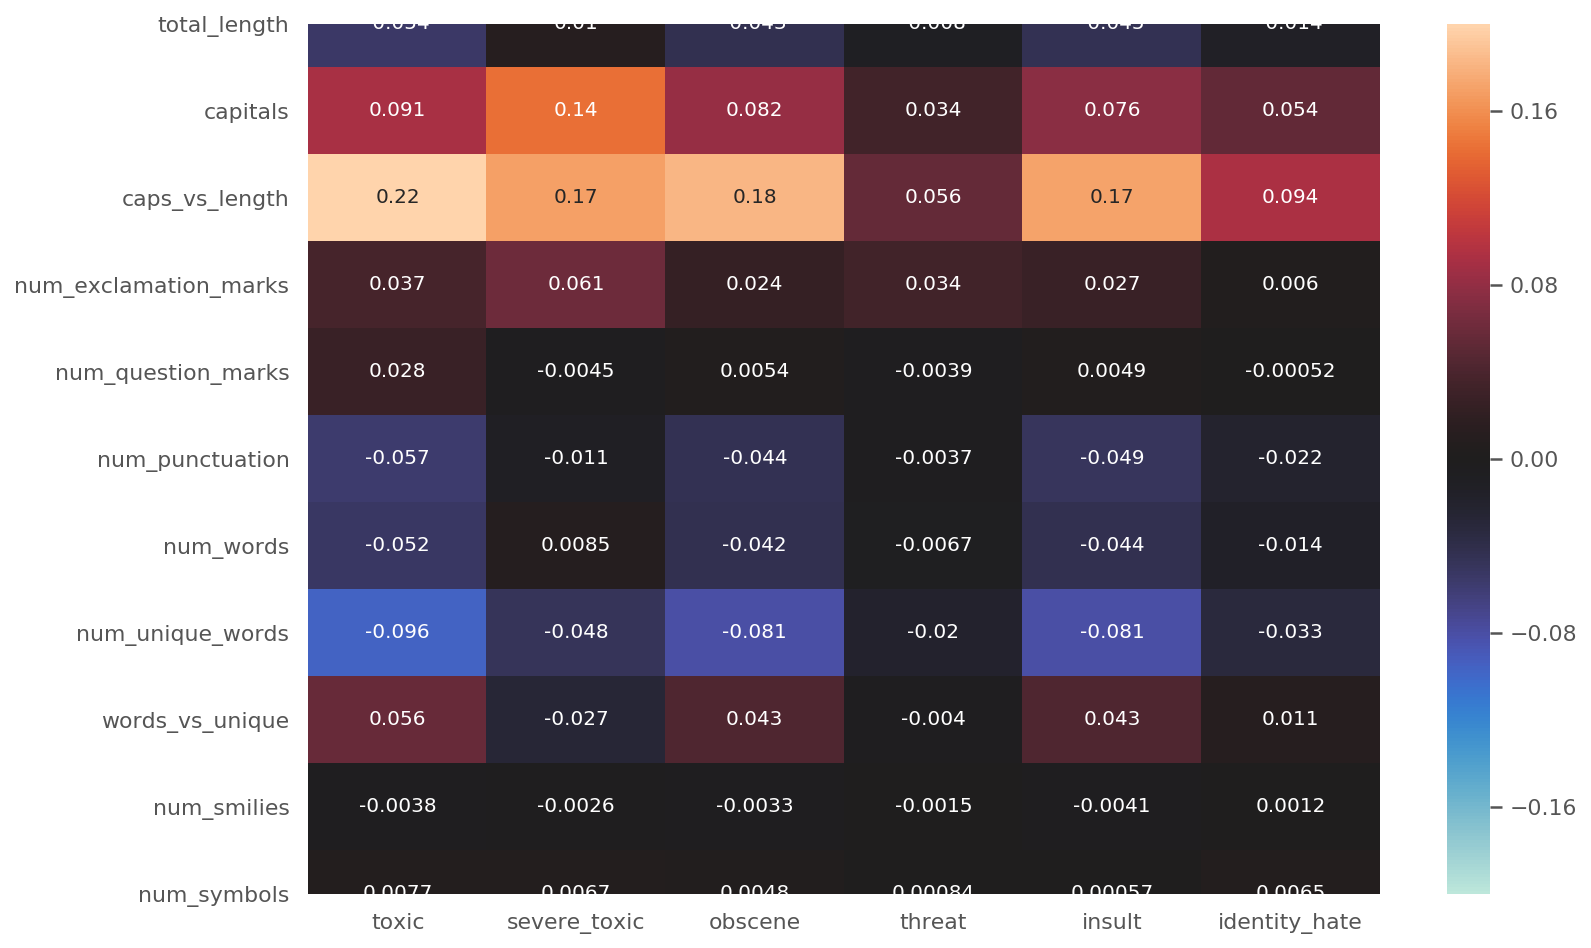

In [0]:
ax = sns.heatmap(df_corr, vmin=-0.2, vmax=0.2, center=0.0,annot=True)

In [0]:
# if the row varies along x-axis the new feature is useful and
# if it's same for all its not useful.
#
# useful features found:
#
# Proportion of capitals
# Number of unique words
# Number of exclamation marks
# Number of punctuations

In [0]:
df_corr.std(axis=1).sort_values(ascending=False)

caps_vs_length           0.061509
capitals                 0.037464
words_vs_unique          0.032472
num_unique_words         0.030480
total_length             0.025462
num_words                0.024337
num_punctuation          0.021978
num_exclamation_marks    0.017933
num_question_marks       0.012020
num_symbols              0.003104
num_smilies              0.001966
dtype: float64

# Basic Text Processing

`You are annoying!!! goJumpOff4Cliff pleaseeeeeeee`

- Step 1 - Remove punctuation → You are annoying goJumpOff4Cliff pleaseeeeeeee
- Step 2 - Remove digits→ You are annoying goJumpOffCliff please
- Step 3 - Split combined words → You are annoying go Jump Off Cliff please
- Step 4 - Convert to lowercase → your are annoying go jump off cliff please
- Step 5 - Split each sentence using delimiter → your, are, annoying, go, jump, off, cliff, please
- Step 6 - Remove stop words → annoying, jump, cliff
- Step 7 - Convert Word to Base Form → annoy, jump, cliff

## Step 1 - Remove Punctuation

In [0]:
import string

df['comment_text'] = df['comment_text'].str.translate(str.maketrans(' ', ' ', string.punctuation))

df.iloc[1,1]

'Daww He matches this background colour Im seemingly stuck with Thanks  talk 2151 January 11 2016 UTC'

# Step 2 - Remove Digits

In [0]:
df['comment_text'] = df['comment_text'].str.translate(str.maketrans(' ', ' ', '\n'))
df['comment_text'] = df['comment_text'].str.translate(str.maketrans(' ', ' ', string.digits))

df.iloc[1,1]

'Daww He matches this background colour Im seemingly stuck with Thanks  talk  January   UTC'

## Step 3 - Split combined words

For instance, converting whyAreYou to why Are You

In [0]:
import re

df['comment_text'] = df['comment_text'].apply(lambda x: re.sub(r'([a-z])([A-Z])',r'\1 \2',x))

df.iloc[1,1]

'Daww He matches this background colour Im seemingly stuck with Thanks  talk  January   UTC'

## Step 4 - Convert to lowercase

In [0]:
df['comment_text'] = df['comment_text'].str.lower()
df.iloc[1,1]

'daww he matches this background colour im seemingly stuck with thanks  talk  january   utc'

## Step 5 - Split each sentence into words

In [0]:
df['comment_text'] = df['comment_text'].str.split()
df.iloc[1,1]

['daww',
 'he',
 'matches',
 'this',
 'background',
 'colour',
 'im',
 'seemingly',
 'stuck',
 'with',
 'thanks',
 'talk',
 'january',
 'utc']

## Step 6 - Remove Stop Words

In [0]:
stop = set(stopwords.words('english'))
df['comment_text'] = df['comment_text'].apply(lambda x: [item for item in x if item not in stop])
df.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,total_length,capitals,caps_vs_length,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,num_words,num_unique_words,words_vs_unique,num_smilies
0,0000997932d777bf,"[explanation, edits, made, username, hardcore, metallica, fan, reverted, werent, vandalisms, closure, gas, voted, new, york, dolls, fac, please, dont, remove, template, talk, page, since, im, retired]",0,0,0,0,0,0,264,17,0.064394,0,1,6,0,43,41,0.953488,0
1,000103f0d9cfb60f,"[daww, matches, background, colour, im, seemingly, stuck, thanks, talk, january, utc]",0,0,0,0,0,0,112,8,0.071429,1,0,5,0,17,17,1.000000,0


## Step 7 - Convert Word to Base Form or Lematize

In [0]:
import nltk
tqdm.pandas()

lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_lst(lst):
    return [lemmatizer.lemmatize(word) for word in lst]



df['comment_text'] = df['comment_text'].progress_apply(lemmatize_lst)

df.head(2)

100%|██████████| 159571/159571 [00:27<00:00, 5892.38it/s]


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,total_length,capitals,caps_vs_length,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,num_words,num_unique_words,words_vs_unique,num_smilies
0,0000997932d777bf,"[explanation, edits, made, username, hardcore, metallica, fan, reverted, werent, vandalism, closure, gas, voted, new, york, doll, fac, please, dont, remove, template, talk, page, since, im, retired]",0,0,0,0,0,0,264,17,0.064394,0,1,6,0,43,41,0.953488,0
1,000103f0d9cfb60f,"[daww, match, background, colour, im, seemingly, stuck, thanks, talk, january, utc]",0,0,0,0,0,0,112,8,0.071429,1,0,5,0,17,17,1.000000,0


# Visualization

In [0]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'total_length', 'capitals', 'caps_vs_length',
       'num_exclamation_marks', 'num_question_marks', 'num_punctuation',
       'num_symbols', 'num_words', 'num_unique_words', 'words_vs_unique',
       'num_smilies'],
      dtype='object')

In [0]:
cols = [ 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
data1 = [df.query(f"""  {x} == 1""").shape[0] for x in cols ]

ser1 = pd.Series(data1, index=cols)
ser1


toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

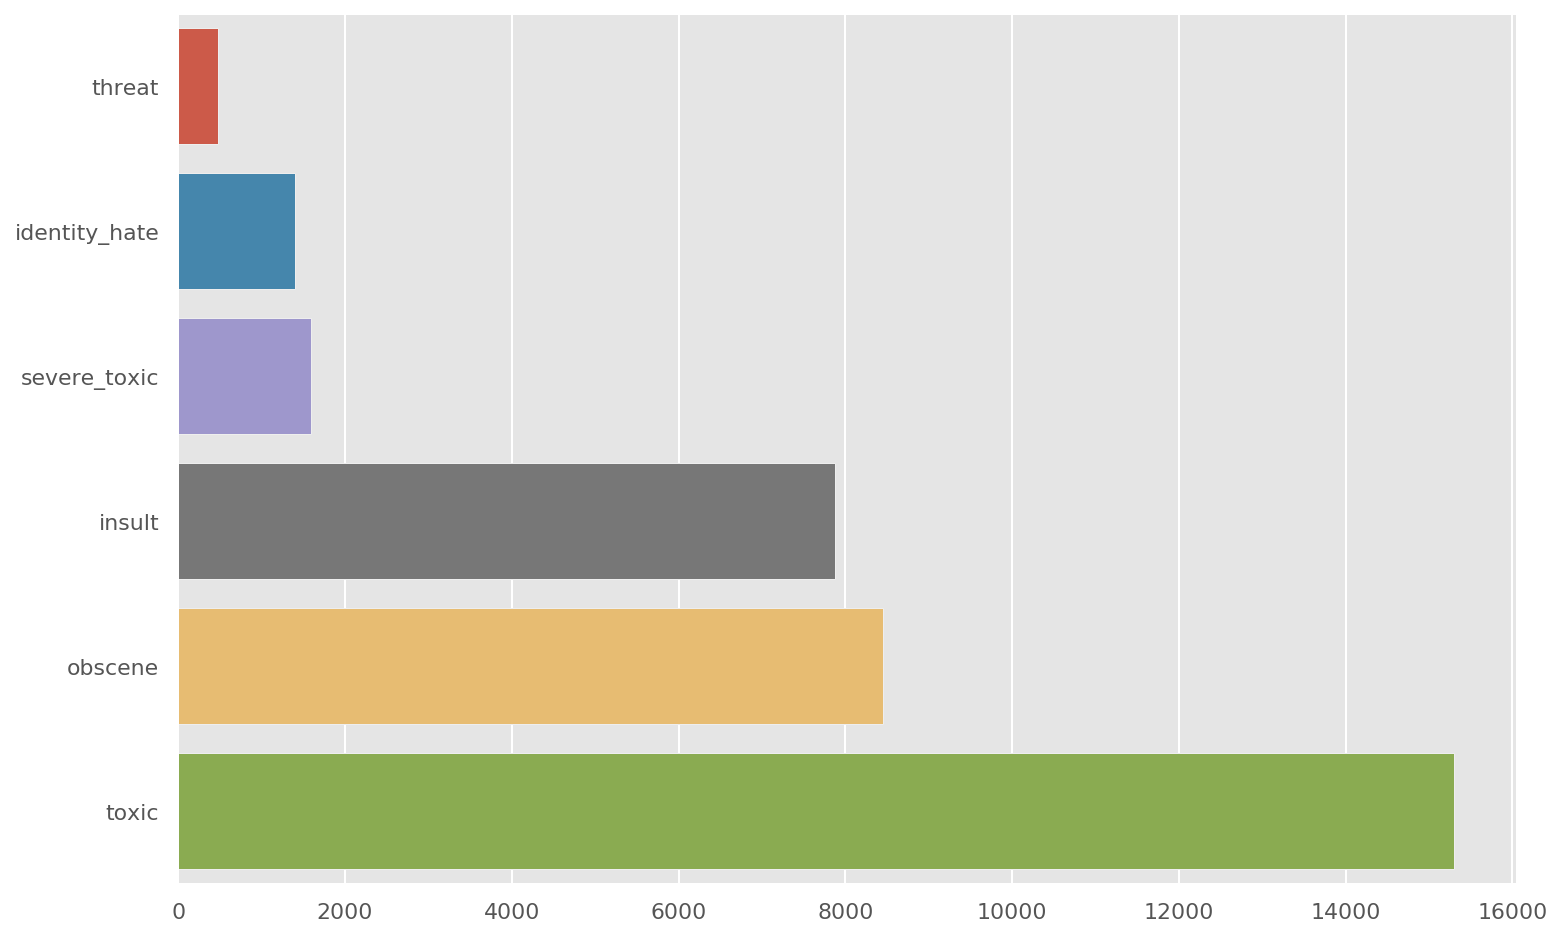

In [0]:
sns.barplot(x=ser1.values, y=cols, order=ser1.sort_values().index)